In [1]:
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *
from ourworldindata_org.collector import get_dataset_df_from_file as get_world_dataset_df_from_file

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch data set from local disk

In [4]:
!ls ~/data/
# gets thte latest file names
recent = ! ls -drt ~/data/* | tail -n 2
print("Latest files are:\n\t{}\n\t{}".format(*recent))

2020-03-31_2058_state_daily_data.csv 2020-03-31_2127_state_rank.csv
2020-03-31_2058_state_rank.csv       2020-03-31_2255_state_daily_data.csv
2020-03-31_2120_state_daily_data.csv 2020-03-31_2255_state_rank.csv
2020-03-31_2120_state_rank.csv       2020-03-31_2300_state_daily_data.csv
2020-03-31_2125_state_daily_data.csv 2020-03-31_2300_state_rank.csv
2020-03-31_2125_state_rank.csv       2020-03-31_2303_state_daily_data.csv
2020-03-31_2127_state_daily_data.csv 2020-03-31_2303_state_rank.csv
Latest files are:
	/Users/drskippy/data/2020-03-31_2303_state_daily_data.csv
	/Users/drskippy/data/2020-03-31_2303_state_rank.csv


In [5]:
df, states_in_order = get_dataset_df_from_file(recent)
df.head()

,date,state,positive,negative,pending,hospitalized,death,total,hash,dateChecked,totalTestResults,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,order,lastUpdateEt
0,2020-03-04,NY,6.0,48.0,24.0,NaN,NaN,78,1afd6e025157a38728847bbf42145c63b024c387,2020-03-04 21:00:00+00:00,54,36,NaN,NaN,NaN,NaN,NaN,0,2020-03-29 09:16:00
1,2020-03-05,NY,22.0,76.0,24.0,NaN,NaN,122,25c15099a4116ff026c04c0b4a6b3780ccba310b,2020-03-05 21:00:00+00:00,98,36,0.0,0.0,28.0,16.0,44.0,0,2020-03-29 09:16:00
2,2020-03-06,NY,33.0,92.0,236.0,NaN,NaN,361,1bd1fecfd3d23311c604ac6c27d05ce5835af2c5,2020-03-06 21:00:00+00:00,125,36,0.0,0.0,16.0,11.0,27.0,0,2020-03-29 09:16:00
3,2020-03-07,NY,76.0,92.0,236.0,NaN,NaN,404,d9b32dfe41c22decc86fe0a35515525a18b68fa9,2020-03-07 21:00:00+00:00,168,36,0.0,0.0,0.0,43.0,43.0,0,2020-03-29 09:16:00
4,2020-03-08,NY,105.0,92.0,NaN,NaN,NaN,197,22912a8c6cdefd796b1412292c796959a8cc088f,2020-03-08 20:00:00+00:00,197,36,0.0,0.0,0.0,29.0,29.0,0,2020-03-29 09:16:00


### SIR Model

In [6]:
dfq, _ = get_state_df(df, "*")
pos_untested = 0.8
dfq["actual_pos"] = dfq.positive.values*(1 + pos_untested)/1000
dfq.head()

,date,positive,negative,pending,totalTestResults,death,lastUpdateEt,daily_new_positive,actual_pos
0,2020-03-04,118.0,748.0,103.0,866,0.0,2020-03-31 18:00:00,NaN,0.2124
1,2020-03-05,176.0,953.0,197.0,1129,0.0,2020-03-31 18:00:00,58.0,0.3168
2,2020-03-06,223.0,1571.0,458.0,1794,0.0,2020-03-31 18:00:00,47.0,0.4014
3,2020-03-07,341.0,1809.0,602.0,2150,0.0,2020-03-31 18:00:00,118.0,0.6138
4,2020-03-08,417.0,2335.0,347.0,2752,0.0,2020-03-31 18:00:00,76.0,0.7506


### SIR Fit

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[ 9.45852066e-05,  4.13815933e-03,  7.30952341e-02],
       [-6.98532221e-04,  8.55135151e-06,  1.07787715e-04],
       [ 3.72424521e-04,  2.86994966e-03,  5.12452671e-02]])
     fun: 2358.1108553403396
 message: 'Optimization terminated successfully.'
    nfev: 702
     nit: 18
  status: 0
 success: True
       x: array([0.3398939 , 0.14843882, 1.09755077])


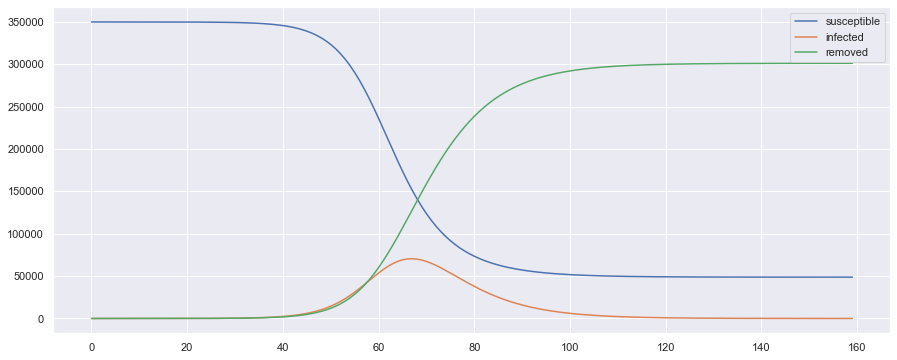

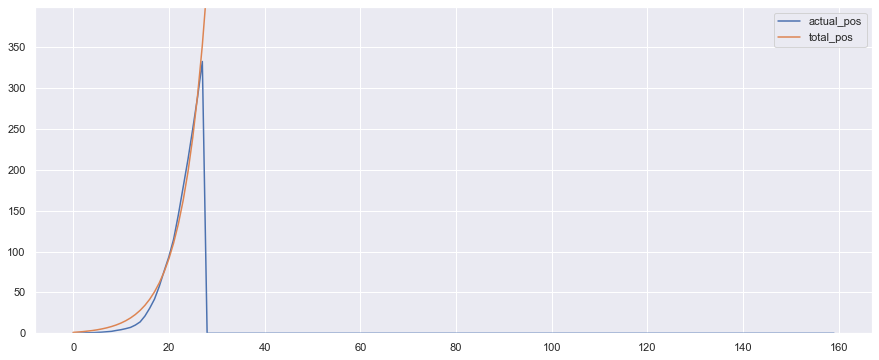

In [7]:
N=350000 
R0=0
x0 = (0.3896, 0.08149, 0.1)
c = dfq.actual_pos.values
SIRFitter(c, N, x0)

In [8]:
dfw, wsl = get_world_dataset_df_from_file()
dfw.head()

,Entity,state,Date,positive,date,lastUpdateEt,negative,pending
0,Afghanistan,AFG,"Dec 31, 2019",0,2019-12-31,2020-03-31 23:04:10.478850,0,0
1,Afghanistan,AFG,"Jan 1, 2020",0,2020-01-01,2020-03-31 23:04:10.478850,0,0
2,Afghanistan,AFG,"Jan 2, 2020",0,2020-01-02,2020-03-31 23:04:10.478850,0,0
3,Afghanistan,AFG,"Jan 3, 2020",0,2020-01-03,2020-03-31 23:04:10.478850,0,0
4,Afghanistan,AFG,"Jan 4, 2020",0,2020-01-04,2020-03-31 23:04:10.478850,0,0


/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[-8.36632971e-04,  6.99556165e-04,  8.47738614e-03],
       [-7.51389122e-05, -1.97980264e-07,  1.70042155e-07],
       [-9.46155004e-05,  9.33422447e-05,  1.66411082e-03]])
     fun: 1736.5178460991854
 message: 'Optimization terminated successfully.'
    nfev: 412
     nit: 10
  status: 0
 success: True
       x: array([0.19628728, 0.08541428, 0.16051272])


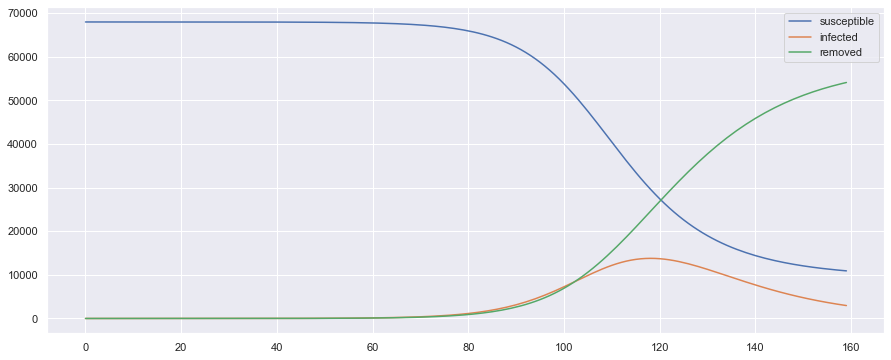

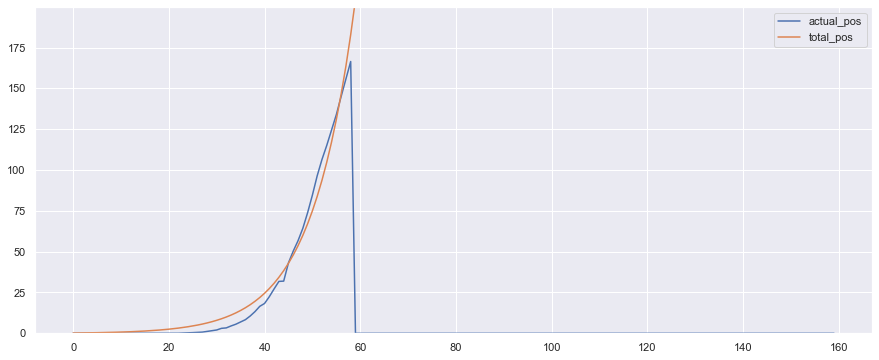

In [9]:
dfq, _ = get_state_df(dfw, "ITA")
pos_untested = 0.8
dfq["actual_pos"] = dfq.positive.values*(1 + pos_untested)/1000
N=68000 
R0=0
x0 = (0.3896, 0.08149, 0.1)
c = np.trim_zeros(dfq.actual_pos.values)
SIRFitter(c, N, x0)

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[ 2.21226641e-03, -5.64653441e-05, -8.71061572e-04],
       [ 6.13853054e-03, -5.85408849e-03, -4.14610641e-02],
       [ 1.23458594e-03, -1.24879386e-05, -4.08315115e-04]])
     fun: 209.10376710325713
 message: 'Optimization terminated successfully.'
    nfev: 839
     nit: 19
  status: 0
 success: True
       x: array([0.23496835, 0.06580205, 0.0060312 ])


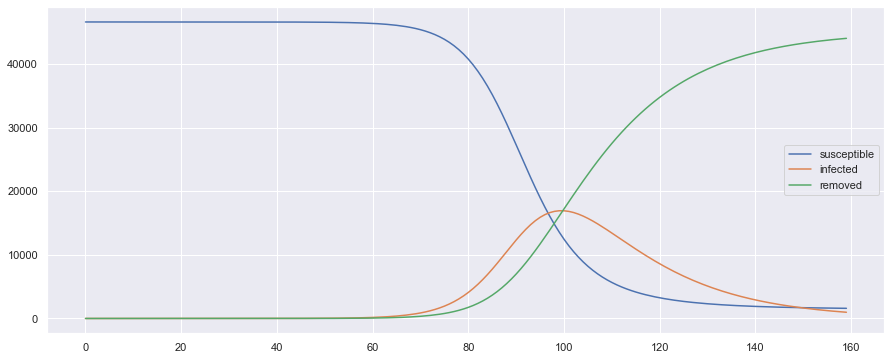

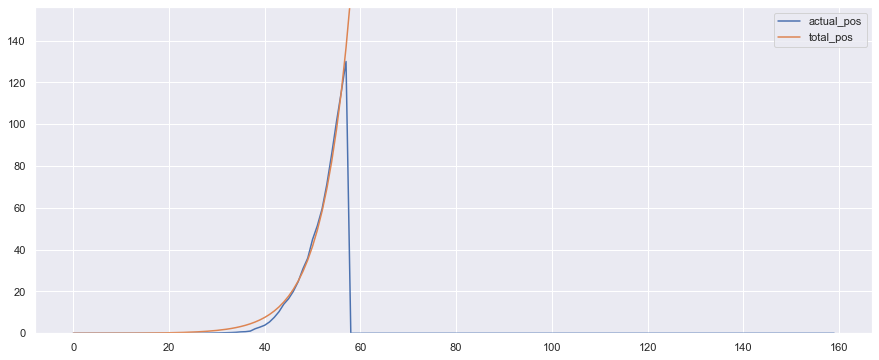

In [10]:
dfq, _ = get_state_df(dfw, "ESP")
pos_untested = 0.8
dfq["actual_pos"] = dfq.positive.values*(1 + pos_untested)/1000
N=46660 
R0=0
x0 = (0.3896, 0.08149, 0.1)
c = np.trim_zeros(dfq.actual_pos.values)
SIRFitter(c, N, x0)